In [1]:
import json, math, requests
import lkh
from pathlib import Path
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from python_tsp.heuristics import solve_tsp_local_search, solve_tsp_simulated_annealing, solve_tsp_lin_kernighan, solve_tsp_record_to_record
from python_tsp.exact import solve_tsp_dynamic_programming
from python_tsp.distances import tsplib_distance_matrix

import time, statistics, random

def euclidean_3d(a, b):
    return math.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2 + (a[2]-b[2])**2)

def tour_length(tour, pts):
    return sum(euclidean_3d(pts[tour[i]], pts[tour[i-1]]) for i in range(len(tour)))

# Wrap each method to a callable taking only dist_matrix and returning (perm, length)
def m_2opt(dm):
    # python-tsp's local_search uses 2-opt by default
    return solve_tsp_local_search(dm)

def m_sa(dm):
    return solve_tsp_simulated_annealing(dm)

def m_ls_ps3_seeded_by_sa(dm):
    # pipeline: SA -> LS(ps3); time includes both
    perm_sa, _ = solve_tsp_simulated_annealing(dm)
    return solve_tsp_local_search(dm, x0=perm_sa, perturbation_scheme="ps3")

def m_dp(dm):
    return solve_tsp_dynamic_programming(dm,maxsize=None)

def m_lk(dm):
    return solve_tsp_lin_kernighan(dm)

def m_rtr(dm):
    return solve_tsp_record_to_record(dm, max_iterations=100)

def time_cpu(fn, *args, **kwargs):
    """Return (result, cpu_seconds), where result is (perm, length)."""
    t0 = time.process_time()
    result = fn(*args, **kwargs)
    dt = time.process_time() - t0
    return result, dt

def bench_once(name, fn, dm, seed=0):
    random.seed(seed); np.random.seed(seed)
    t0_cpu = time.process_time()
    perm, length = fn(dm)
    cpu_s = time.process_time() - t0_cpu
    return name, cpu_s, length, perm

# Create distanc matrix from 3D points wihtout using TSPLIB format
def dm_from_pts(pts):
    n = len(pts)
    dm = np.zeros((n,n))
    for i in range(n):
        for j in range(i+1,n):
            d = euclidean_3d(pts[i], pts[j])
            dm[i,j] = d
            dm[j,i] = d
    return dm

# Create TSP files using the WORKING LKH method
def create_tsp_with_lkh(filename, name, points):
    """Create TSP file using LKH library - WORKING VERSION"""
    problem = lkh.LKHProblem()
    problem.name = name
    problem.type = "TSP"  
    problem.dimension = len(points)
    problem.edge_weight_type = "EXACT_3D"
    
    # The key: use node_coords (dict) not node_coord_section (list)
    node_coords = {}
    for i, (x, y, z) in enumerate(points, 1):
        node_coords[i] = (x, y, z)
    problem.node_coords = node_coords
    
    with open(filename, 'w') as f:
        f.write(problem.render())

In [2]:
# Read marker data from all 3 JSON files
mrk_path = Path("ScannedPoints.mrk.json")
with mrk_path.open() as f:
    data = json.load(f)
    if data:
        print("Successfully loaded marker data")
    else:
        print("Failed to load marker data")
        exit(1)
        
# Points are in markups[0].controlPoints[*].position = [x,y,z]
pts = [tuple(cp["position"]) for cp in data["markups"][0]["controlPoints"]]
print(f"Loaded {len(pts)} points from {mrk_path}")

# Read marker data from second JSON file
mrk_path2 = Path("ScannedPoints-2.mrk.json")
with mrk_path2.open() as f:
    data = json.load(f)
    if data:
        print("Successfully loaded marker data")
    else:
        print("Failed to load marker data")
        exit(1)

# Points are in markups[0].controlPoints[*].position = [x,y,z]
pts2 = [tuple(cp["position"]) for cp in data["markups"][0]["controlPoints"]]
print(f"Loaded {len(pts2)} points from {mrk_path2}")

# Read marker data from third JSON file
mrk_path3 = Path("ScannedPoints-3.mrk.json")
with mrk_path3.open() as f:
    data = json.load(f)
    if data:
        print("Successfully loaded marker data")
    else:
        print("Failed to load marker data")
        exit(1)

# Points are in markups[0].controlPoints[*].position = [x,y,z]
pts3 = [tuple(cp["position"]) for cp in data["markups"][0]["controlPoints"]]
print(f"Loaded {len(pts3)} points from {mrk_path3}")

# Create all TSP files using working LKH method
scan3d = Path("scan3d.tsp")
create_tsp_with_lkh(scan3d, "scan3d", pts)
print(f"Wrote {scan3d}")
    
scan3d_2 = Path("scan3d_2.tsp")
create_tsp_with_lkh(scan3d_2, "scan3d_2", pts2)
print(f"Wrote {scan3d_2}")

scan3d_3 = Path("scan3d_3.tsp")
create_tsp_with_lkh(scan3d_3, "scan3d_3", pts3)
print(f"Wrote {scan3d_3}")
        
dist_matrix = tsplib_distance_matrix("scan3d.tsp")
dist_matrix2 = tsplib_distance_matrix("scan3d_2.tsp")
dist_matrix3 = tsplib_distance_matrix("scan3d_3.tsp")

Successfully loaded marker data
Loaded 357 points from ScannedPoints.mrk.json
Successfully loaded marker data
Loaded 374 points from ScannedPoints-2.mrk.json
Successfully loaded marker data
Loaded 257 points from ScannedPoints-3.mrk.json
Wrote scan3d.tsp
Wrote scan3d_2.tsp
Wrote scan3d_3.tsp


In [3]:
# ---- choose methods -------------------------------------------------------
methods = [
    ("2-opt (local search)",   m_2opt),
    ("Simulated annealing",    m_sa),
    ("SA → LS (ps3)",          m_ls_ps3_seeded_by_sa),
    ("Lin–Kernighan",          m_lk),  
    #("Record to Record",       m_rtr),
]

# Define datasets with their info
datasets = [
    ("Dataset 1", dist_matrix, len(pts), "scan3d.tsp"),
    ("Dataset 2", dist_matrix2, len(pts2), "scan3d_2.tsp"),
    ("Dataset 3", dist_matrix3, len(pts3), "scan3d_3.tsp"),
]

# Store results for comparison
all_results = {}  # {dataset_name: {method_name: (cpu_time, length)}}

# Run each method on each dataset
for dataset_name, dm, n_points, filename in datasets:
    all_results[dataset_name] = {}
    
    for method_name, method_fn in methods:
        _, cpu_s, length, perm = bench_once(method_name, method_fn, dm, seed=123)
        all_results[dataset_name][method_name] = (cpu_s, length)

In [4]:
# ================ BENCHMARK RESULTS ================
print("\nBENCHMARK RESULTS")
print("="*70)

# 1. Progress report for each dataset
for dataset_name, _, n_points, _ in datasets:
    print(f"\n--- {dataset_name} (n={n_points}) ---")
    for method_name, _ in methods:
        if method_name in all_results[dataset_name]:
            cpu_time, length = all_results[dataset_name][method_name]
            print(f"{method_name:22s}  CPU {cpu_time:8.4f} s   length {length:.3f}")

# 2. Results table by method (CPU time)
print("\n" + "="*70)
print("COMPARISON ANALYSIS")
print("="*70)

print("\n1. RESULTS BY METHOD (CPU Time)")
print("-" * 70)
header = f"{'Method':<22} {'Dataset 1':<15} {'Dataset 2':<15} {'Dataset 3':<15}"
print(header)
print("-" * 70)

for method_name, _ in methods:
    line = f"{method_name:<22} "
    for dataset_name, _, _, _ in datasets:
        if method_name in all_results[dataset_name]:
            cpu_time, length = all_results[dataset_name][method_name]
            if cpu_time == float('inf'):
                line += f"{'FAILED':<15} "
            else:
                line += f"{cpu_time:8.4f}s     "
        else:
            line += f"{'N/A':<15} "
    print(line)

# 3. Tour lengths comparison
print(f"\n2. TOUR LENGTHS COMPARISON")
print("-" * 70)
header = f"{'Method':<22} {'Dataset 1':<15} {'Dataset 2':<15} {'Dataset 3':<15}"
print(header)
print("-" * 70)

for method_name, _ in methods:
    line = f"{method_name:<22} "
    for dataset_name, _, _, _ in datasets:
        if method_name in all_results[dataset_name]:
            cpu_time, length = all_results[dataset_name][method_name]
            if length == float('inf'):
                line += f"{'FAILED':<15} "
            else:
                line += f"{length:10.1f}     "
        else:
            line += f"{'N/A':<15} "
    print(line)

# 4. Summary statistics
print("\n3. SUMMARY STATISTICS")
print("-" * 70)
for dataset_name, _, n_points, _ in datasets:
    print(f"\n{dataset_name} (n={n_points:3d}):")
    
    # Best tour length
    valid_results = [(method, length) for method, (cpu_time, length) in all_results[dataset_name].items() 
                     if length != float('inf')]
    if valid_results:
        best_method, best_length = min(valid_results, key=lambda x: x[1])
        print(f"Best tour length:  {best_method:<22} length={best_length:.1f}")
    
    # Fastest method
    valid_results = [(method, cpu_time) for method, (cpu_time, length) in all_results[dataset_name].items() 
                     if cpu_time != float('inf')]
    if valid_results:
        fastest_method, fastest_time = min(valid_results, key=lambda x: x[1])
        print(f"Fastest solution: {fastest_method:<22} time={fastest_time:.4f}s")


BENCHMARK RESULTS

--- Dataset 1 (n=357) ---
2-opt (local search)    CPU   8.0008 s   length 636.629
Simulated annealing     CPU  16.9606 s   length 645.633
SA → LS (ps3)           CPU  31.8479 s   length 614.214
Lin–Kernighan           CPU   0.3291 s   length 607.810

--- Dataset 2 (n=374) ---
2-opt (local search)    CPU  10.0955 s   length 694.779
Simulated annealing     CPU  18.5311 s   length 714.908
SA → LS (ps3)           CPU  33.8194 s   length 682.243
Lin–Kernighan           CPU   0.2593 s   length 689.998

--- Dataset 3 (n=257) ---
2-opt (local search)    CPU   3.4351 s   length 467.374
Simulated annealing     CPU   9.6275 s   length 451.894
SA → LS (ps3)           CPU  14.9613 s   length 437.181
Lin–Kernighan           CPU   0.1864 s   length 438.382

COMPARISON ANALYSIS

1. RESULTS BY METHOD (CPU Time)
----------------------------------------------------------------------
Method                 Dataset 1       Dataset 2       Dataset 3      
--------------------------------

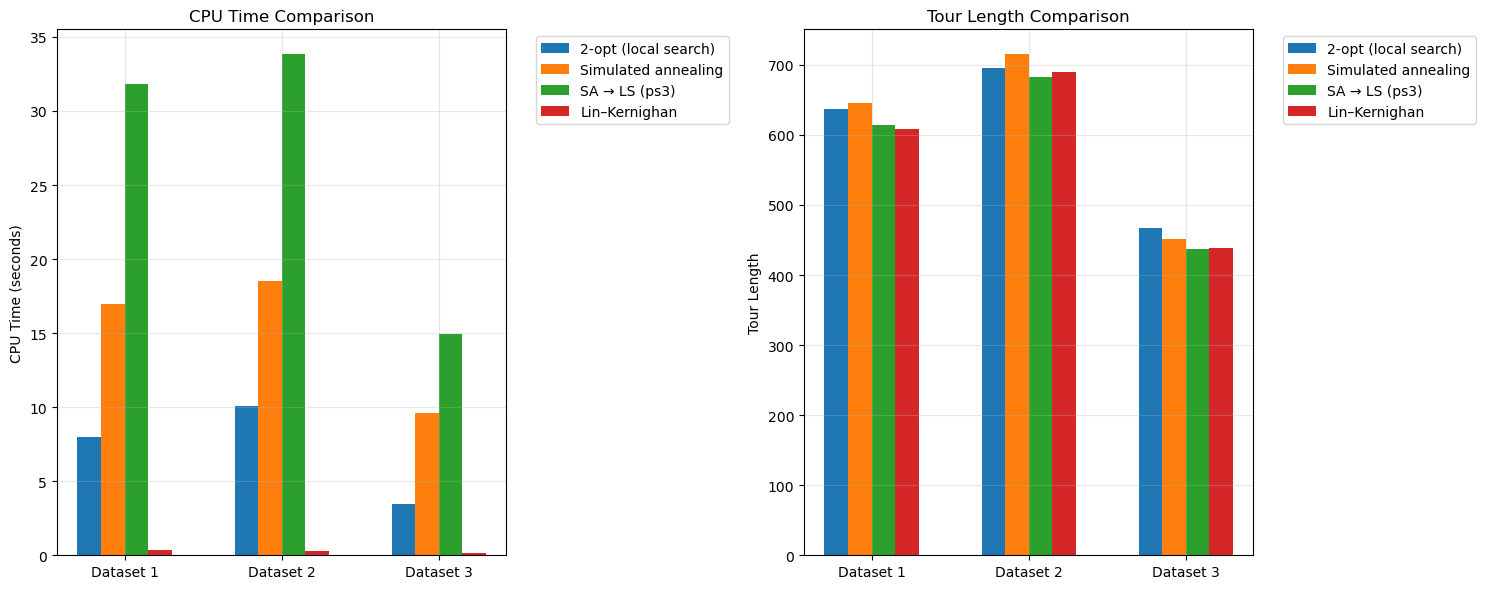


Best Performing Methods:

Dataset 1:
Fastest Method: Lin–Kernighan (0.3291s)
Best Tour:     Lin–Kernighan (length: 607.8)

Dataset 2:
Fastest Method: Lin–Kernighan (0.2593s)
Best Tour:     SA → LS (ps3) (length: 682.2)

Dataset 3:
Fastest Method: Lin–Kernighan (0.1864s)
Best Tour:     SA → LS (ps3) (length: 437.2)


In [5]:
# Create a comprehensive visualization comparing all methods and datasets
import matplotlib.pyplot as plt
import numpy as np

# Prepare data for plotting
method_names = [name for name, _ in methods]
dataset_names = [name for name, _, _, _ in datasets]

# Create arrays for CPU times and tour lengths
cpu_times = np.zeros((len(methods), len(datasets)))
tour_lengths = np.zeros((len(methods), len(datasets)))

for i, method_name in enumerate(method_names):
    for j, dataset_name in enumerate(dataset_names):
        if method_name in all_results[dataset_name]:
            cpu_time, length = all_results[dataset_name][method_name]
            cpu_times[i, j] = cpu_time
            tour_lengths[i, j] = length

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot CPU times
x = np.arange(len(dataset_names))
width = 0.15  # Width of bars
multiplier = 0

for i, method_name in enumerate(method_names):
    offset = width * multiplier
    rects = ax1.bar(x + offset, cpu_times[i], width, label=method_name)
    multiplier += 1

# Customize CPU times plot
ax1.set_ylabel('CPU Time (seconds)')
ax1.set_title('CPU Time Comparison')
ax1.set_xticks(x + width * (len(method_names) - 1) / 2)
ax1.set_xticklabels(dataset_names)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

# Plot tour lengths
multiplier = 0
for i, method_name in enumerate(method_names):
    offset = width * multiplier
    rects = ax2.bar(x + offset, tour_lengths[i], width, label=method_name)
    multiplier += 1

# Customize tour lengths plot
ax2.set_ylabel('Tour Length')
ax2.set_title('Tour Length Comparison')
ax2.set_xticks(x + width * (len(method_names) - 1) / 2)
ax2.set_xticklabels(dataset_names)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

# Print the best performing method for each metric
print("\nBest Performing Methods:")
print("=" * 50)

# For each dataset
for j, dataset_name in enumerate(dataset_names):
    print(f"\n{dataset_name}:")
    
    # Find fastest method
    fastest_idx = np.argmin(cpu_times[:, j])
    print(f"Fastest Method: {method_names[fastest_idx]} ({cpu_times[fastest_idx, j]:.4f}s)")
    
    # Find best tour length
    best_tour_idx = np.argmin(tour_lengths[:, j])
    print(f"Best Tour:     {method_names[best_tour_idx]} (length: {tour_lengths[best_tour_idx, j]:.1f})")